In [1]:
#from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#import os
#import shutil
#import h5py
from scipy import io
from scipy import signal
#import glob
import csv
from biosppy.signals import ecg
from sklearn.preprocessing import LabelEncoder

preparing data for training

In [2]:
arr = []

with open('../training2017/REFERENCE.csv', newline='') as csvfile:
    
     spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        
     for row in spamreader:
        
         spam = row[0].split(',')
            
         if spam[1] == 'A': # af ecg
            
            arr.append(spam[0])
            
print (len(arr))            

738


(14938, 256, 1)
(14938,) 26


/home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/ipykernel_launcher.py:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


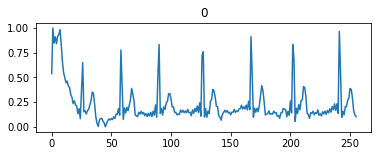

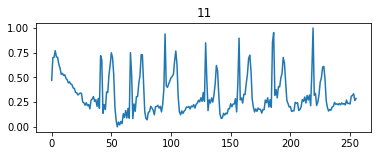

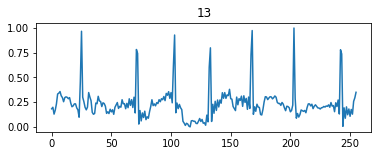

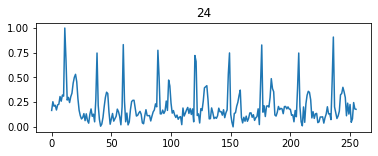

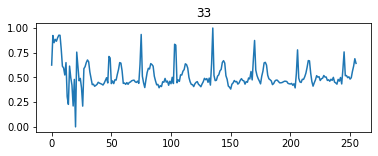

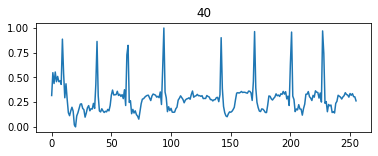

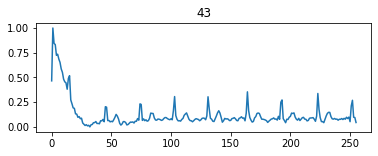

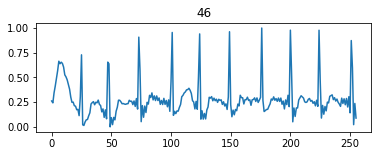

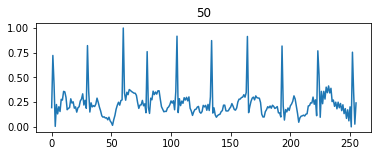

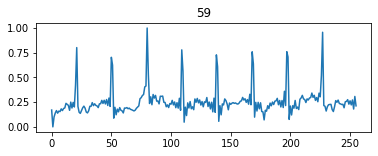

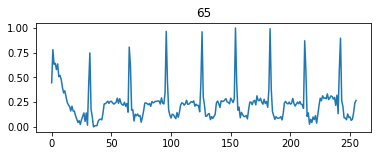

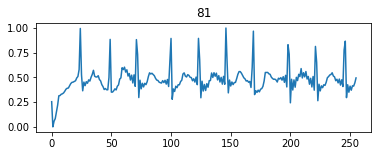

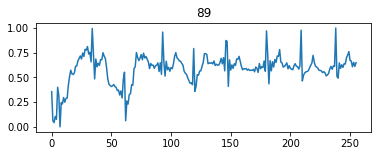

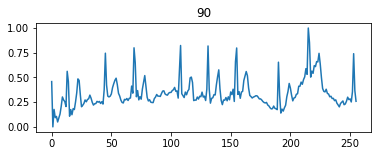

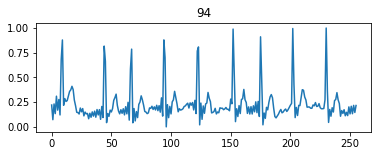

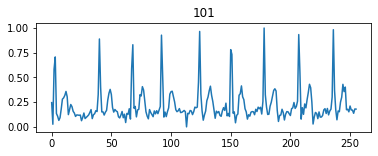

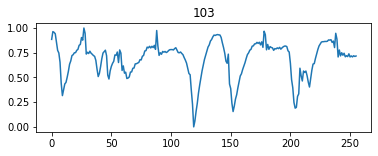

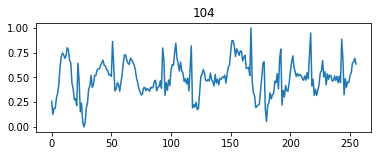

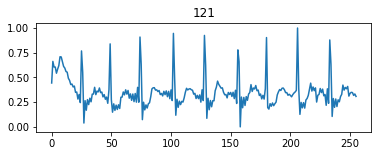

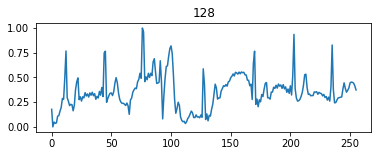

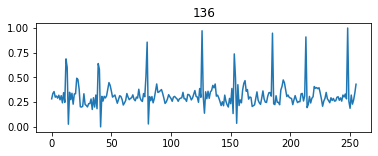

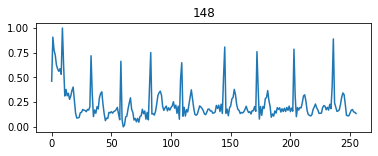

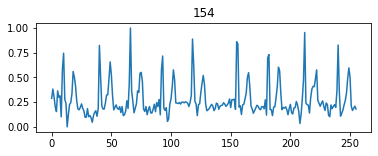

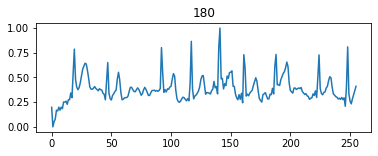

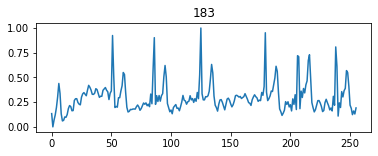

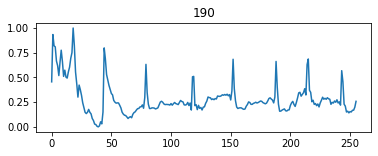

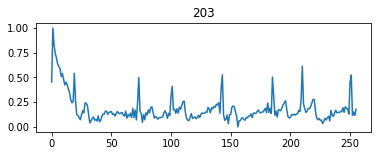

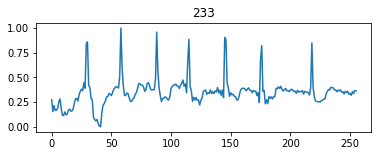

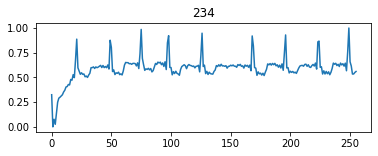

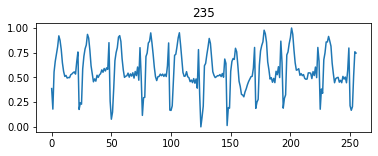

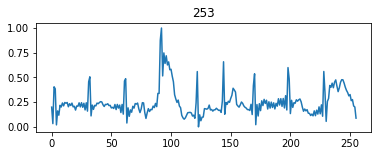

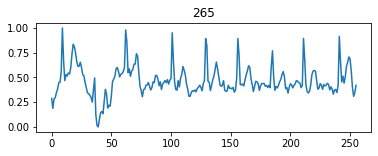

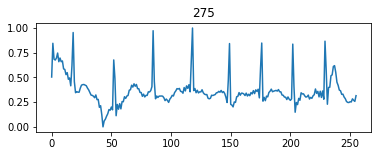

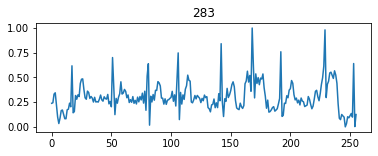

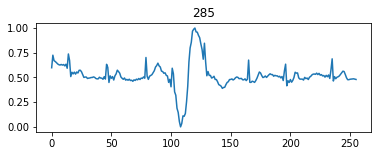

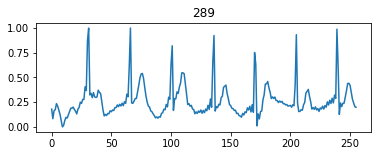

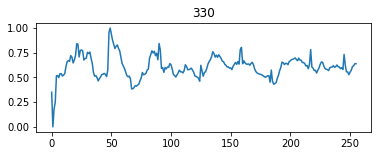

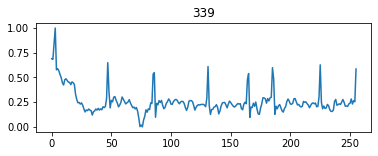

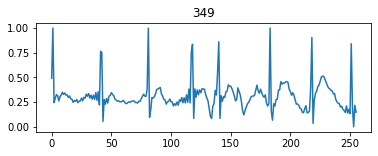

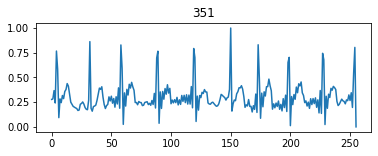

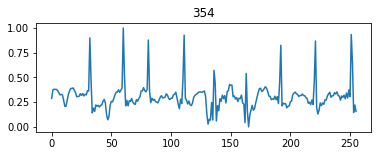

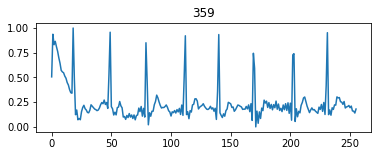

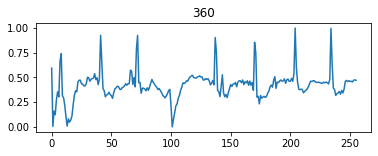

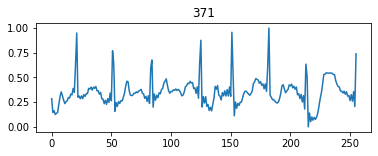

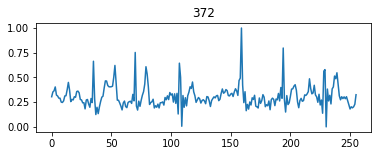

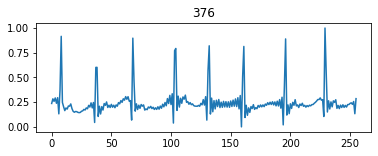

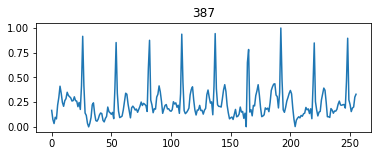

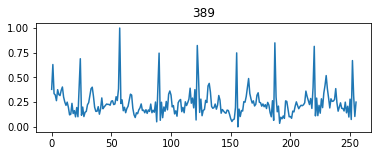

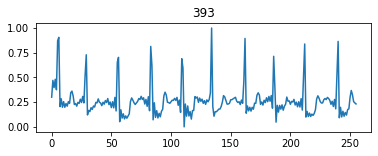

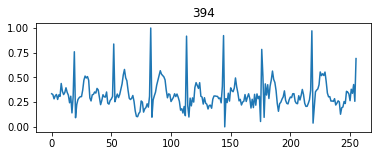

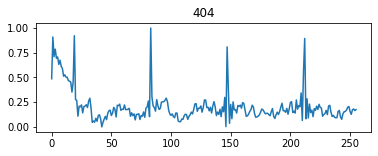

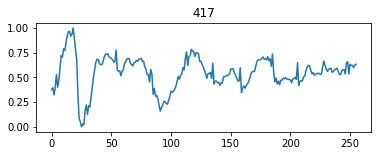

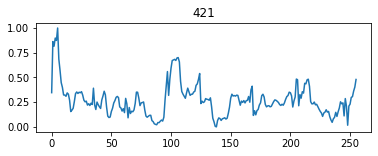

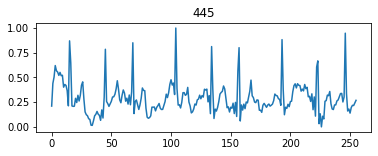

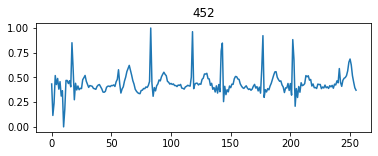

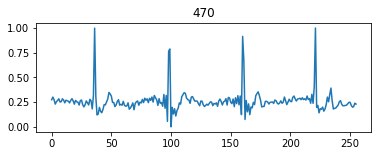

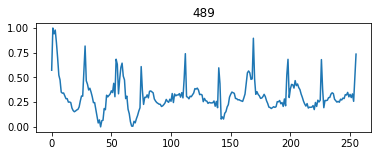

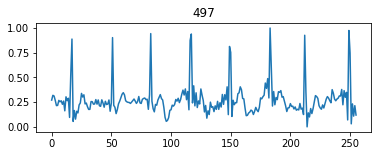

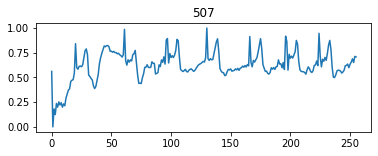

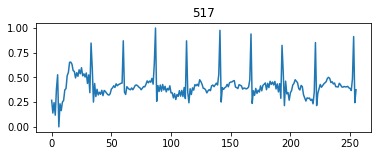

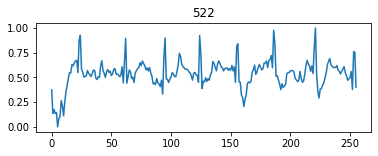

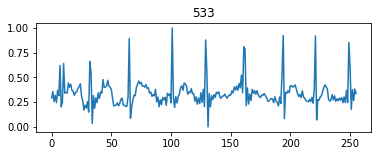

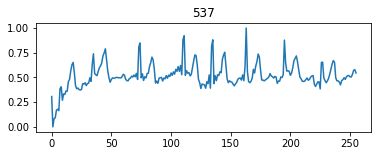

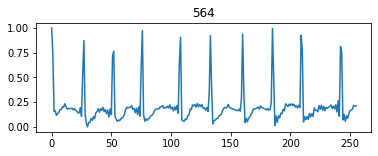

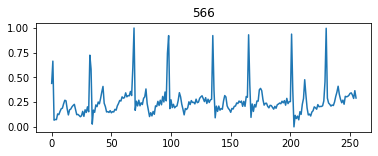

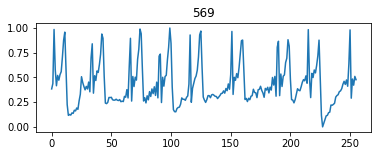

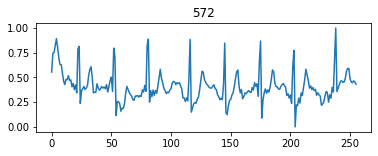

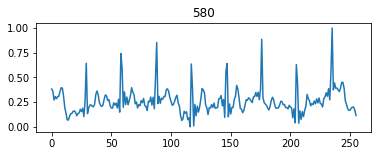

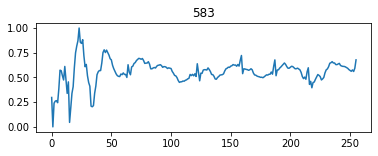

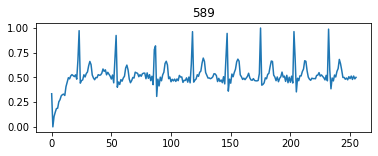

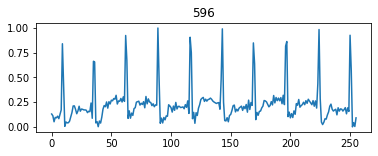

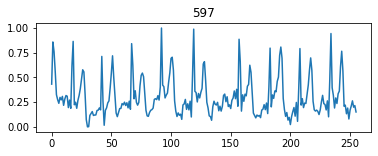

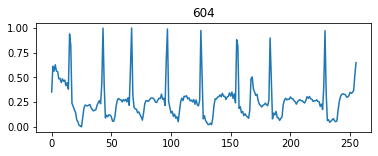

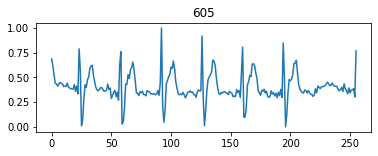

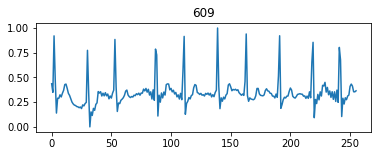

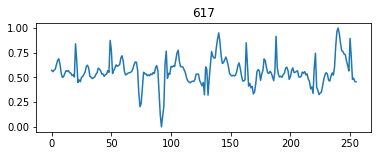

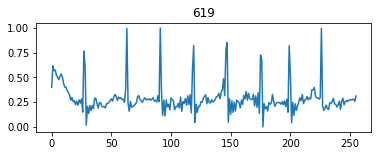

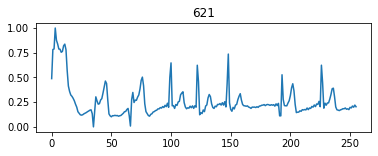

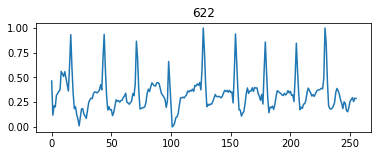

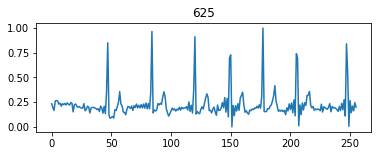

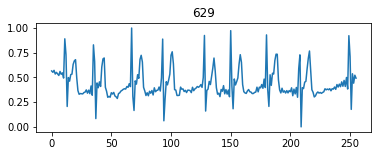

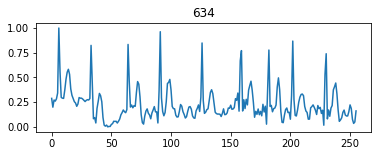

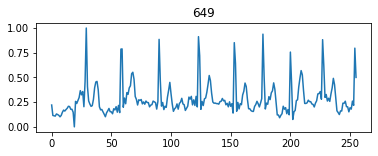

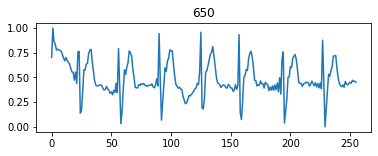

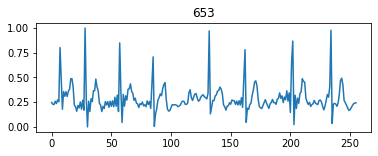

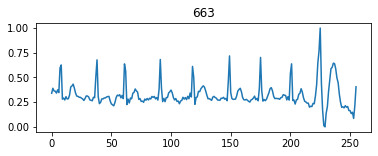

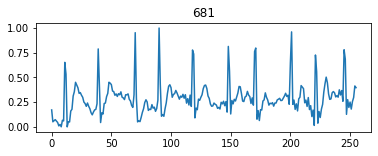

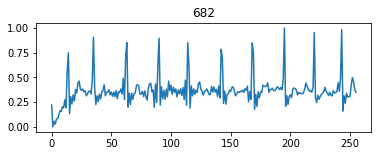

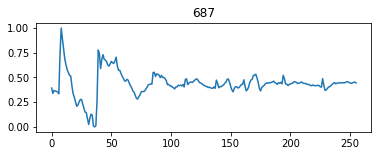

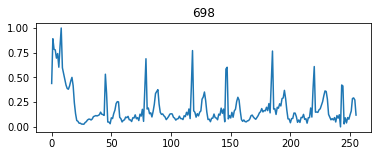

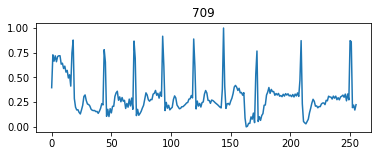

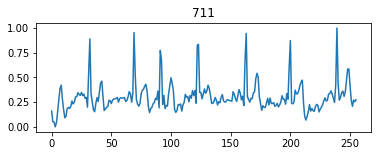

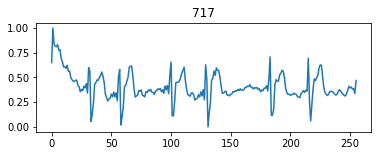

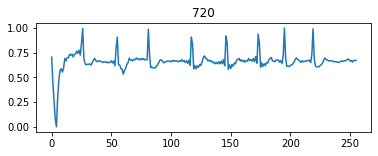

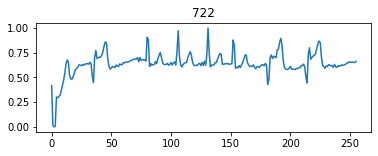

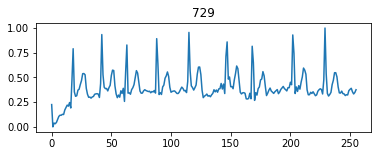

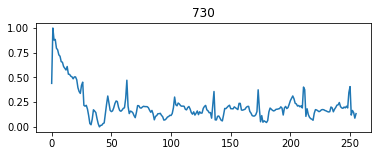

In [3]:
l = 738 # number of samples 
d = 9000 # minimal length
r = 1024 # subsampling
w = 256 # window size
st = 5 # step size for windowing
hwm = 700 # how many windows
ahwm = 0

data = [] # actual raw data
length = [] # original sample lengths
hrm = [] # means of heart rate
hrv = [] # variances of heart rate
list = [] # list of selected samples

c = 0 # how many peaks above
cc = 0 # how many peaks below
cl = 0.0 # weight for max
ccll = 0.0 # weight for min
#thm = 100 # coefficient for mean
#thhm = 100 # coefficient for mean
#thv = 0.25 # coefficient for variance
#thhv = 0.25 # coefficient for variance
rmin = 50 # minimum heart rate
rmax = 90 # maximum heart rate

dbr = io.loadmat('../training2017/' + arr[0]) 
dummyr = dbr['val'][0, :]
outr = ecg.ecg(signal=dummyr, sampling_rate=300, show=False)

# pick a reference template
for I in range(5): # it is used for extracting right and left leads
    
    temp = outr['templates'][I].reshape(-1, 1) 
    mintemp = np.amin(temp)
    maxtemp = np.amax(temp)
    temp = (temp-mintemp)/(maxtemp-mintemp) # normalization
    tempp = outr['templates'][I+1].reshape(-1, 1) 
    mintempp = np.amin(tempp)
    maxtempp = np.amax(tempp)
    tempp = (tempp-mintempp)/(maxtempp-mintempp) # normalization
    
    if I == 0:
        
        gor = signal.correlate(temp[:,0], tempp[:,0], 'same')/5.0 
        
    else: 
        
        gor += signal.correlate(temp[:,0], tempp[:,0], 'same')/5.0 

for i in range(l):
    
    db = io.loadmat('../training2017/' + arr[i]) 
    dummy = db['val'][0, :]
    
    out = ecg.ecg(signal=dummy, sampling_rate=300., show=False)
    
    length.append(len(dummy))
    
    min = np.amin(dummy)
    max = np.amax(dummy)
    
    if len(dummy) < d: # samples should have at least 9000 points
        
        dummy = np.append(dummy, dummy)
        dummy = np.append(dummy, dummy)
        
    dummy = dummy[0:d]    
    
    # removing samples with big corrupted parts
    L = np.where(dummy >= cl*max)
    LL = np.where(dummy <= ccll*min)
    
    for I in range(5): # it is used for extracting right and left leads
    
        temp = outr['templates'][I].reshape(-1, 1) # pick a reference template
        mintemp = np.amin(temp)
        maxtemp = np.amax(temp)
        temp = (temp-mintemp)/(maxtemp-mintemp) # normalization
        temps = out['templates'][I].reshape(-1, 1)
        mintemps = np.amin(temps)
        maxtemps = np.amax(temps)
        temps = (temps-mintemps)/(maxtemps-mintemps) # normalization
        
        if I == 0:
            
            go = signal.correlate(temp[:,0], temps[:,0], 'same')/5.0
            
        else:
            
            go += signal.correlate(temp[:,0], temps[:,0], 'same')/5.0
            
    if (len(L[0]) > c and len(LL[0]) > cc and
        np.amax(out['heart_rate']) < rmax and np.amin(out['heart_rate']) > rmin and
        np.amax(np.abs(go)) <= 1.8*np.amax(np.abs(gor))): 
       '''and np.sqrt(np.var(L)) > r*thv and np.sqrt(np.var(LL)) > r*thhv and np.abs(np.mean(L) - r/2.0) < thm and np.abs(np.mean(LL) - r/2.0) < thhm''' 
        
        
       dummy = signal.resample(dummy, r) # subsampling
    
       list.append(i)

       ahwm = 0
    
       for j in range(hwm):
        
            if j*st+w >= len(dummy):
            
                break;
            
            ahwm = ahwm + 1
            
            # normalization    
            minn = np.amin(dummy[j*st:j*st+w])
            maxx = np.amax(dummy[j*st:j*st+w])
            ddata = (dummy[j*st:j*st+w]-minn)/(maxx-minn)
            
            hrm.append(round(np.mean(out['heart_rate']), 0))
            hrv.append(round(np.var(out['heart_rate']), 0))          
            data.append(ddata) 
            
data = np.asarray(data).reshape(len(data), w, 1)

# create hr for class labels from hrm and/or hrv
hrm = np.asarray(hrm).reshape(len(data))
hrv = np.asarray(hrv).reshape(len(data))
hr = np.copy(hrm) # or = np.copy(hrm*hrv)

seq_in = np.copy(data) # training data
print (seq_in.shape)  

#print (length)

# create class labels from hr
encoder = LabelEncoder()
encoder.fit(hr)
hr = encoder.transform(hr)
print (hr.shape, len(np.unique(hr)))  

counter = 0
for i in range(0, len(seq_in), ahwm): # list of samples selected (look at the plot's title)
    
    plt.figure(figsize=(6, 2))
    plt.plot(seq_in[i, :, 0])
    plt.title(np.str(list[counter]))
    counter = counter + 1

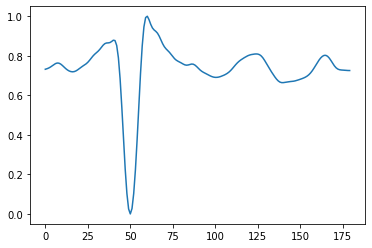

In [4]:
# little testing on templates
db = io.loadmat('../training2017/' + arr[718]) # 718 is a different lead so it is not part of the training data
dummy = db['val'][0, :]
out = ecg.ecg(signal=dummy, sampling_rate=300, show=False)
temp = out['templates'][0].reshape(-1, 1) 
mintemp = np.amin(temp)
maxtemp = np.amax(temp)
temp = (temp-mintemp)/(maxtemp-mintemp) # normalization
plt.plot(temp)

CNN GAN for ECG data

In [5]:
import sys
from keras.layers import Input, Dense, Reshape, Dropout, MaxPooling1D, Conv1D, Flatten, UpSampling1D, ZeroPadding1D
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l1_l2
import keras.backend as K
from keras.models import model_from_json

Using TensorFlow backend.


In [6]:
class GAN():
    
    def __init__(self, rows, channels, classes):
        
        self.seq_length = rows
        self.channels = channels
        self.latent_dim = 100
        self.critic_loss = []
        self.gen_loss = []
        self.clip_value = 0.1
        self.n_critic = 5   
        self.num_classes = classes
        
        optimizer_c = Adam(0.0002, 0.5)
        optimizer_g = Adam(0.0004, 0.5)
        
        self.critic = self.build_critic()
        self.critic.compile(loss='binary_crossentropy', optimizer=optimizer_c, metrics=['accuracy'])

        self.generator = self.build_generator()             
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        generated_seq = self.generator([z, label])
        self.critic.trainable = False
        validity = self.critic([generated_seq, label])
        self.combined = Model([z, label], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_g)

    def build_critic(self):

        model = Sequential()           
        
        model.add(Conv1D(filters=16, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Conv1D(filters=32, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))    
        model.add(Conv1D(filters=64, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4)) 
        model.add(Conv1D(filters=128, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dropout(0.4))        
        model.add(Flatten())         
        model.add(Dense(1, activation='sigmoid'))
        
        seq = Input(shape=(self.seq_length, self.channels))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.seq_length)(label))
        model_input = multiply([seq, label_embedding])
        
        validity = model(model_input)

        return Model([seq, label], validity)
      
    def build_generator(self):

        model = Sequential()    
        
        l = np.int(self.seq_length/16.0)
        model.add(Dense(l*128, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((l, 128)))
        model.add(UpSampling1D(2))
        model.add(Conv1D(128, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling1D(2))
        model.add(Conv1D(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))        
        model.add(UpSampling1D(2))
        model.add(Conv1D(32, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling1D(2))
        model.add(Conv1D(16, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))        
        model.add(Conv1D(self.channels, kernel_size=6, padding='same'))
        model.add(Activation('sigmoid'))        
        
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        
        seq = model(model_input)

        return Model([noise, label], seq)

    def train(self, epochs, batch_size=64, sample_interval=100):

        X_train = np.copy(seq_in)  
        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            for _ in range(self.n_critic): # having multiple critics
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_seqs = X_train[idx]
                label = hr[idx]
                
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim)) 
                
                gen_seqs = self.generator.predict([noise, label])            

                d_loss_real = self.critic.train_on_batch([real_seqs, label], real)
                d_loss_fake = self.critic.train_on_batch([gen_seqs, label], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                for l in self.critic.layers: # weight clipping
                    
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)

            g_loss = self.combined.train_on_batch([noise, label], real)

            if epoch % sample_interval == 0:
                
              print ('%d [D loss: %f] [G loss: %f]' % (epoch, d_loss[0], g_loss))
              
              self.critic_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
            
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.critic_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title('GAN Loss per Epoch')
        plt.legend(['critic', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [ ]:
gan = GAN(rows=seq_in.shape[1], channels=seq_in.shape[2], classes=len(np.unique(hr)))    

gan.train(epochs=20000, batch_size=64, sample_interval=100)

W0916 18:45:26.399306 140223594940224 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 18:45:26.401518 140223594940224 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 18:45:26.403613 140223594940224 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 18:45:26.466841 140223594940224 deprecation_wrapper.py:119] From /home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name 

0 [D loss: 0.689753] [G loss: 0.696692]


/home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


generate synthetic ecg

In [ ]:
hwmn = 2 # how many synthetic signals are needed

noise = np.random.normal(0, 1, (hwmn, gan.latent_dim))
gen_seqs = gan.generator.predict([noise, hr[0:hwmn]]).reshape(hwmn, gan.seq_length) # change hr[0:hwmn] if different classes are required

for i in range(hwmn):

    plt.figure(figsize=(6, 2))
    plt.plot(gen_seqs[i])

In [ ]:
print('saved model to disk')

model = gan.generator
model_json = model.to_json()

with open('gan.json', 'w') as json_file:
    
    json_file.write(model_json)
    
model.save_weights('gan.h5')

In [ ]:
print('loaded model from disk')

json_file = open('gan.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights('gan.h5')

In [ ]:
# try with loaded_model 
hwmn = 2 # how many synthetic signals are needed

noise = np.random.normal(0, 1, (hwmn, gan.latent_dim))
gen_seqs = loaded_model.predict([noise, hr[0:hwmn]]).reshape(hwmn, gan.seq_length) # change hr[0:hwmn] if different classes are required

for i in range(hwmn):

    plt.figure(figsize=(6, 2))
    plt.plot(gen_seqs[i])